In [1]:
import os
os.chdir("..")

import numpy as np
import torch
from src.randomizedSignature import rSig, rSigKer
from src.neuralSigKers import NeuralSigKer
from src.utils import augment_with_time
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Utils

In [2]:
def generate_BM(batch, timesteps, d, T=1.0):
    
    times = torch.linspace(0., T, timesteps)
    dt = times[1]
    
    dB = np.sqrt(dt)*torch.normal(0,1.0,size = (batch, timesteps-1, d)).to(device)
    dB = torch.cat((torch.zeros((batch, 1, d)).to(device).float(), dB), dim=1)
    
    # B: (batch, timesteps, d)
    B = dB.cumsum(dim=1) 
    
    return B

def generate_paths(batch, timesteps):
    
    times = torch.linspace(0., 1, timesteps)
    
    x = torch.stack([np.sin(w*times).double() for w in np.linspace(5,8,batch) ])
    x = x[..., None]

    y = torch.stack([np.cos(w*times).double() + 3*np.exp(times).double() for w in np.linspace(13,16,batch)])
    y = y[..., None]
    
    return torch.cat([x, y], dim=-1)

# Randomized Signatures

## Generate Datasets

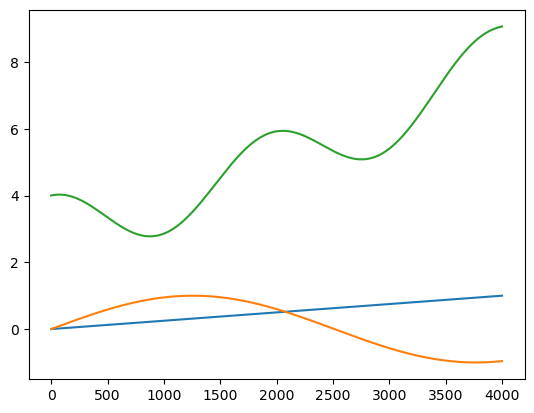

In [3]:
# Hyperparameters
batch, timesteps, d = 4, 4000, 2
ReLU = lambda x : x * (x > 0)

# Data
# I: (timesteps, )
I = torch.linspace(0, 1.0, timesteps)
# X: (batch, timesteps, 1+d)
X = augment_with_time(generate_BM(batch, timesteps, d))
# Y: (batch, timesteps, 1+2)
Y = augment_with_time(generate_paths(batch, timesteps))

#plt.plot(X[0, :,1], X[0, :,2])
plt.plot(Y[0])

## rSig 

In [36]:
data = Y
N = 100

d_augmented = data.shape[-1]
sigmas = [.4, 0.3, 1.2]

model = rSig(input_channels=d_augmented,
             hidden_channels=N,
             activation=ReLU,
             sigmas=sigmas)

In [37]:
# Compute only last value.
# S_0: (batch, N)
S_0 = model.forward(data, interval=I)/np.sqrt(N) 

# Compute whole path.
# S_1: (batch, timesteps, N)
S_1 = model.forward(data, interval = I, interval_return=I)/np.sqrt(N) # (batch, timesteps, N)

# (S_1[:, -1, :] ==  S_0).all() is True

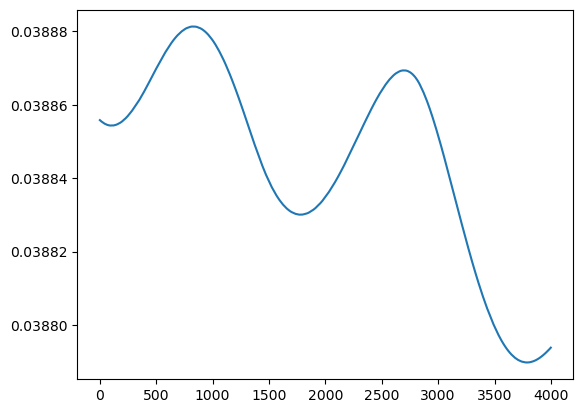

In [41]:
plt.plot(S_1[1, :, 0])

## rSigKer

In [43]:
Kernel = rSigKer(hidden_dim=100,
                 MC_iters=20,
                 activation=ReLU,
                 sigmas=sigmas)

In [45]:
G = Kernel.compute_Gram_matrix(X, X, interval_return=I)
M = Kernel.metric(X, X)

In [47]:
sigmas = {"sigma_0": 1.0, "sigma_A": 1.0, "sigma_b": 1.0}

sigmas["sigma_0"]

1.0

# Neural SigKer

## Generate Datasets

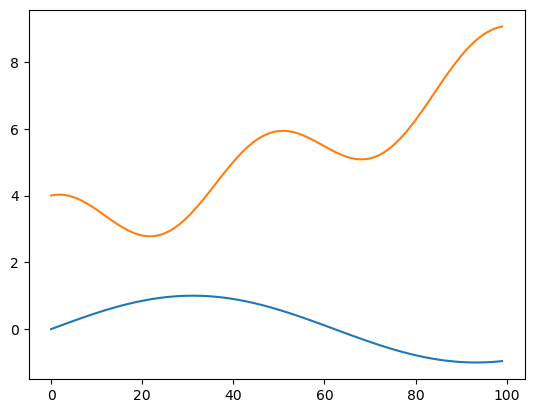

In [7]:
# Hyperparameters
batch, timesteps = 80, 100
ReLU = lambda x : x * (x > 0)

# data: (batch, timesteps, 2)
data = generate_paths(batch, timesteps)
X = data[..., 0].unsqueeze(-1)
Y = data[..., 1].unsqueeze(-1)

#plt.plot(X[0, :,1], X[0, :,2])
plt.plot(data[0])

In [11]:
neural_Kernel = NeuralSigKer()

K = neural_Kernel.kernel(X, Y, sym=False, max_batch=50)
K.shape

torch.Size([80, 80, 100, 100])